# Simulation vs Analytical — MRT con IC su batch

Questo notebook fornisce funzioni per:
- caricare uno o più file CSV di **batch** (con colonne come `SCOPE, ARRIVAL_RATE, BATCH_NUM, MEAN_RESPONSE_TIME, ...`);
- caricare automaticamente il **modello analitico** (curva MRT teorica) cercando un CSV con pattern comuni (es. `analytic_sweep_lambda.csv`);
- calcolare **intervalli di confidenza** t-Student tra batch per la **Mean Response Time (MRT)**;
- produrre **4 figure** separate: `SYSTEM` (simulazione ± IC e curva analitica) e i tre nodi `A`, `B`, `P` (solo simulazione).

## Requisiti minimi dei dati
- CSV dei batch: deve contenere almeno queste colonne
  - `SCOPE` (es. `OVERALL`, `A`, `B`, `P`),
  - `ARRIVAL_RATE`,
  - `BATCH_NUM` (intero che identifica il batch),
  - `MEAN_RESPONSE_TIME`.
- CSV analitico: deve contenere
  - `arrival_rate` o `lambda`,
  - una colonna di MRT di sistema (sarà rilevata automaticamente tra: `mean_response_time`, `mrt`, `system_mean_response_time`, `MRT`),
  - opzionale `X_max` (asintoto/limite).

> Nota: le figure sono **separate** (non subplot) per rispettare i vincoli della piattaforma.

In [1]:
# Import principali (niente seaborn né stili personalizzati)
import os, glob, math, re
from pathlib import Path
from typing import Optional, Union, Iterable, Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Funzioni di supporto generali ----

def _ensure_dataframe(files_or_df: Union[str, Path, pd.DataFrame, Iterable[Union[str, Path]]]) -> pd.DataFrame:
    """
    Converte input vari (path singolo, lista di path, DataFrame) in un DataFrame unico.
    - Accetta anche wildcard (es. 'out/*.csv').
    - Aggiunge colonna 'SOURCE' con il path origine per debug/tracking.
    """
    # Se è già un DataFrame, clona
    if isinstance(files_or_df, pd.DataFrame):
        df = files_or_df.copy()
        if 'SOURCE' not in df.columns:
            df['SOURCE'] = '<dataframe>'
        return df

    # Normalizza a lista di path
    paths: List[Path] = []
    if isinstance(files_or_df, (str, Path)):
        files_or_df = [files_or_df]

    for item in files_or_df:
        p = Path(item)
        if any(ch in str(p) for ch in ['*', '?', '[']):
            for m in glob.glob(str(p)):
                paths.append(Path(m))
        elif p.is_dir():
            for m in sorted(p.glob('*.csv')):
                paths.append(m)
        else:
            paths.append(p)

    frames = []
    for p in paths:
        if p.exists() and p.suffix.lower() == '.csv':
            dfi = pd.read_csv(p)
            dfi['SOURCE'] = str(p)
            frames.append(dfi)
    if not frames:
        raise FileNotFoundError("Nessun CSV trovato/valido nell'input passato.")
    return pd.concat(frames, ignore_index=True)

In [4]:
# ---- Caricamento modello analitico (ricerca per pattern) ----

def find_analytic_csv_for_config(config_path: Union[str, Path], base_dir: Optional[Union[str, Path]] = None) -> str:
    """
    Trova il CSV analitico associato a una config.
    Pattern cercati (in ordine di priorità):
      - {base_dir}/analytic_sweep_{cfg_name}*.csv
      - {base_dir}/{cfg_name}_analytic*.csv
      - {base_dir}/analytic_sweep_lambda.csv
      - {parent(base_dir)}/analytic_sweep_lambda.csv
    """
    config_path = Path(config_path)
    if base_dir is None:
        base_dir = config_path.parent
    base_dir = Path(base_dir)

    cfg_name = config_path.stem
    patterns = [
        base_dir / f"analytic_sweep_{cfg_name}*.csv",
        base_dir / f"{cfg_name}_analytic*.csv",
        base_dir / "analytic_sweep_lambda.csv",
        base_dir.parent / "analytic_sweep_lambda.csv",
    ]

    candidates: List[str] = []
    for pat in patterns:
        matches = glob.glob(str(pat))
        candidates.extend(matches)

    if not candidates:
        raise FileNotFoundError(
            f"Nessun CSV analitico trovato per '{cfg_name}'. "
            f"Cercati pattern: {patterns}"
        )

    # Ordina dando precedenza ai nomi più specifici (più lunghi), poi alfabetico
    candidates.sort(key=lambda p: (len(Path(p).name), p), reverse=True)
    return candidates[0]


def load_analytic_models_for_config(config_path: Union[str, Path], base_dir: Optional[Union[str, Path]] = None) -> pd.DataFrame:
    """
    Carica il CSV analitico e uniforma i nomi colonna:
      - 'lambda' -> 'arrival_rate'
      - rileva la colonna della MRT di sistema (tra: mean_response_time, mrt, system_mean_response_time, MRT)
      - opzionale 'X_max'
    """
    path = find_analytic_csv_for_config(config_path, base_dir=base_dir)
    df = pd.read_csv(path)

    # Uniforma colonna della lambda
    if "arrival_rate" not in df.columns and "lambda" in df.columns:
        df = df.rename(columns={"lambda": "arrival_rate"})

    if "arrival_rate" not in df.columns:
        raise ValueError("Il CSV analitico deve contenere almeno 'arrival_rate' o 'lambda'.")

    # Identifica la colonna di MRT (sistema)
    mrt_candidates = [c for c in df.columns if c.lower() in {"mean_response_time", "mrt", "system_mean_response_time"}]
    if not mrt_candidates:
        # Fallback: prova con 'MEAN_RESPONSE_TIME'
        mrt_candidates = [c for c in df.columns if c.upper() == "MEAN_RESPONSE_TIME"]
    if not mrt_candidates:
        raise ValueError("Il CSV analitico deve contenere una colonna MRT (es. 'mean_response_time' o 'mrt').")

    # Mantieni solo le colonne utili (+ X_max se presente)
    keep = ["arrival_rate", mrt_candidates[0]]
    if "X_max" in df.columns:
        keep.append("X_max")

    df = df[keep].sort_values("arrival_rate").reset_index(drop=True)
    # Rinomina la MRT analitica a un nome standard
    df = df.rename(columns={mrt_candidates[0]: "MRT_analytic"})
    return df

In [6]:
# ---- Calcolo IC t-Student su batch per MRT ----

def _t_critical(conf: float, df: int) -> float:
    """
    Ritorna il quantile t-Student per il livello di confidenza 'conf' e gradi di libertà 'df'.
    - Tenta 'scipy.stats.t' se disponibile; altrimenti usa approssimazione Normale (z) per df >= 30.
    """
    alpha = 1.0 - conf
    try:
        from scipy.stats import t as student_t  # type: ignore
        return float(student_t.ppf(1.0 - alpha/2.0, df))
    except Exception:
        # Approssimazione ragionevole per df grandi
        if df >= 30:
            return 1.96 if abs(conf - 0.95) < 1e-9 else 2.576 if abs(conf - 0.99) < 1e-9 else 1.64
        # Per df piccoli senza SciPy: fallback prudente (più largo)
        return 2.20  # circa per df ~ 15 a 95%

def _standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Uniforma nomi colonne critiche se necessario.
    """
    ren = {}
    if "vscope" in df.columns and "SCOPE" not in df.columns:
        ren["vscope"] = "SCOPE"
    if "lambda" in df.columns and "ARRIVAL_RATE" not in df.columns:
        ren["lambda"] = "ARRIVAL_RATE"
    if "batch" in df.columns and "BATCH_NUM" not in df.columns:
        ren["batch"] = "BATCH_NUM"
    if ren:
        df = df.rename(columns=ren)
    return df

def ci_from_batches_mrt(batch_csv_input: Union[str, Path, pd.DataFrame, Iterable[Union[str, Path]]],
                        conf: float = 0.95) -> pd.DataFrame:
    """
    Calcola media e semi-ampiezza IC per la MRT raggruppando per (SCOPE, ARRIVAL_RATE).
    Ritorna un DataFrame con colonne: SCOPE, ARRIVAL_RATE, mean, half, n_batches.
    """
    df = _ensure_dataframe(batch_csv_input)
    df = _standardize_columns(df)

    # Controlli minimi
    required = {"SCOPE", "ARRIVAL_RATE", "BATCH_NUM"}
    if not required.issubset(df.columns):
        raise ValueError(f"Mancano colonne richieste nel CSV batch: {required - set(df.columns)}")

    # Colonna MRT: prova nomi comuni
    mrt_col = None
    for c in ["MEAN_RESPONSE_TIME", "mean_response_time", "MRT"]:
        if c in df.columns:
            mrt_col = c
            break
    if mrt_col is None:
        raise ValueError("Non trovo la colonna della MRT (attesi: 'MEAN_RESPONSE_TIME' / 'mean_response_time' / 'MRT').")

    # Tipizzazione
    df["ARRIVAL_RATE"] = pd.to_numeric(df["ARRIVAL_RATE"], errors="coerce")
    df["BATCH_NUM"]    = pd.to_numeric(df["BATCH_NUM"],    errors="coerce")
    df[mrt_col]        = pd.to_numeric(df[mrt_col],         errors="coerce")
    df = df.dropna(subset=["ARRIVAL_RATE", "BATCH_NUM", mrt_col])

    # Calcolo media per batch (già aggregato nel CSV), poi IC su groupby (SCOPE, ARRIVAL_RATE)
    # Se nel CSV c'è più di una riga per batch (es. per scope differenti), la groupby sottostante isola correttamente.
    grp = df.groupby(["SCOPE", "ARRIVAL_RATE"], as_index=False)

    # Aggrega: media tra batch, std e n
    agg = grp.agg(
        mean=(mrt_col, "mean"),
        std=(mrt_col, "std"),
        n_batches=("BATCH_NUM", "nunique")
    )

    # Semi-ampiezza IC
    half_list = []
    for _, row in agg.iterrows():
        k = int(row["n_batches"])
        if k <= 1 or pd.isna(row["std"]) or row["std"] == 0:
            half_list.append(0.0)
        else:
            tcrit = _t_critical(conf, k - 1)
            half_list.append(tcrit * (row["std"] / math.sqrt(k)))

    agg["half"] = half_list
    return agg[["SCOPE", "ARRIVAL_RATE", "mean", "half", "n_batches"]].sort_values(["SCOPE", "ARRIVAL_RATE"]).reset_index(drop=True)

In [7]:
# ---- Funzioni di plotting (4 figure separate) ----

def _line_with_band(ax, x, mean, half, label_mean: str, label_band: str, ci_text: str, fill: bool = True):
    """
    Disegna la linea della media e opzionalmente la banda ±half.
    """
    (h_line,) = ax.plot(x, mean, marker='o', label=label_mean)
    h_band = None
    if fill and np.any(np.array(half) > 0):
        upper = np.array(mean) + np.array(half)
        lower = np.array(mean) - np.array(half)
        h_band = ax.fill_between(x, lower, upper, alpha=0.2, label=label_band)
    # Aggiunge una legenda compatta
    handles = [h for h in [h_line, h_band] if h is not None]
    ax.legend(handles=handles, loc="best", frameon=True)
    # Facoltativo: indicazione testuale del livello di confidenza
    ax.set_title(f"{ax.get_title()}")
    return h_line, h_band

def plot_mrt_system_with_analytic(ci_df: pd.DataFrame, analytic_df: pd.DataFrame, conf: float = 0.95):
    """
    Figura 1 — SYSTEM: media ± IC (batch) + curva analitica.
    """
    # Filtra SYSTEM / OVERALL
    sys = ci_df[ci_df["SCOPE"].str.upper().isin(["OVERALL", "SYSTEM"])].copy()
    if sys.empty:
        raise ValueError("Non trovo righe SCOPE=OVERALL/SYSTEM nei dati batch.")
    sys = sys.sort_values("ARRIVAL_RATE")
    x = sys["ARRIVAL_RATE"].to_numpy()
    y = sys["mean"].to_numpy()
    h = sys["half"].to_numpy()

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_title("SYSTEM — Mean Response Time (MRT)")
    ax.set_xlabel("λ (arrival rate)")
    ax.set_ylabel("MRT")

    _line_with_band(ax, x, y, h, label_mean="simulation mean", label_band=f"± t-IC {int(conf*100)}%", ci_text="", fill=True)

    # Curva analitica
    model = analytic_df.sort_values("arrival_rate")
    ax.plot(model["arrival_rate"], model["MRT_analytic"], linestyle="--", marker="s", label="analytical model")
    ax.legend(loc="best", frameon=True)

    # Asintoto/limite opzionale
    if "X_max" in analytic_df.columns and pd.notna(analytic_df["X_max"].iloc[0]):
        try:
            x_max = float(analytic_df["X_max"].iloc[0])
            ax.axvline(x_max, linestyle="--", alpha=0.7)
        except Exception:
            pass

    plt.tight_layout()
    plt.show()

def plot_mrt_node(ci_df: pd.DataFrame, scope_name: str, conf: float = 0.95):
    """
    Figura per un nodo (A, B, P): media ± IC (batch). Nessuna curva analitica.
    """
    d = ci_df[ci_df["SCOPE"].str.upper() == scope_name.upper()].copy()
    if d.empty:
        # Se mancante, esci silenziosamente
        return
    d = d.sort_values("ARRIVAL_RATE")
    x = d["ARRIVAL_RATE"].to_numpy()
    y = d["mean"].to_numpy()
    h = d["half"].to_numpy()

    fig, ax = plt.subplots(figsize=(7, 4.5))
    ax.set_title(f"{scope_name} — Mean Response Time (MRT)")
    ax.set_xlabel("λ (arrival rate)")
    ax.set_ylabel("MRT")

    _line_with_band(ax, x, y, h, label_mean="simulation mean", label_band=f"± t-IC {int(conf*100)}%", ci_text="", fill=True)
    plt.tight_layout()
    plt.show()

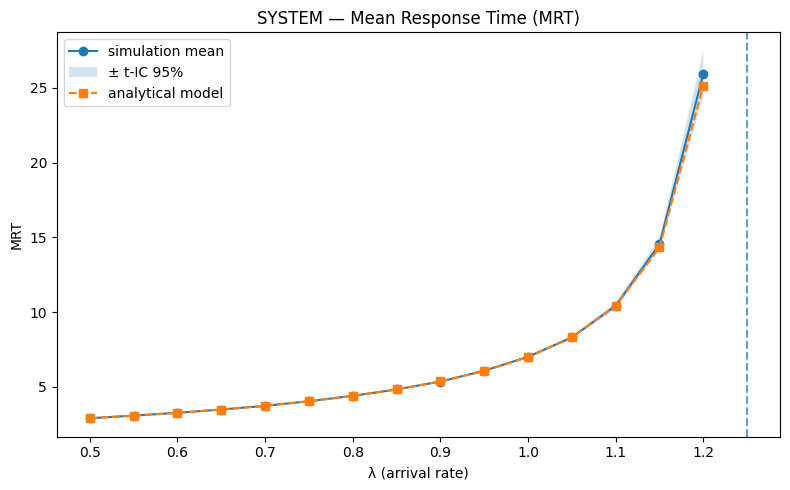

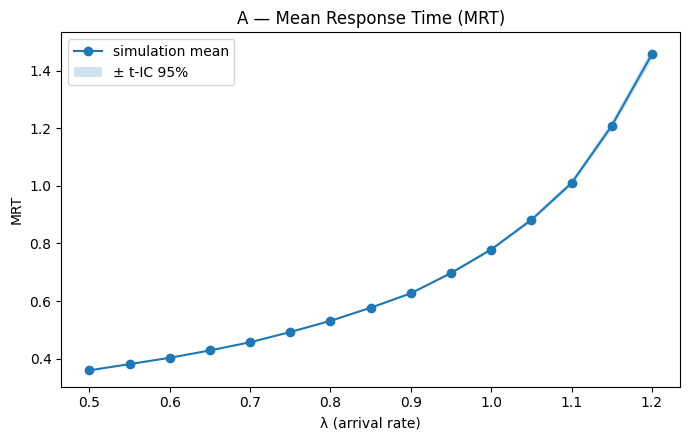

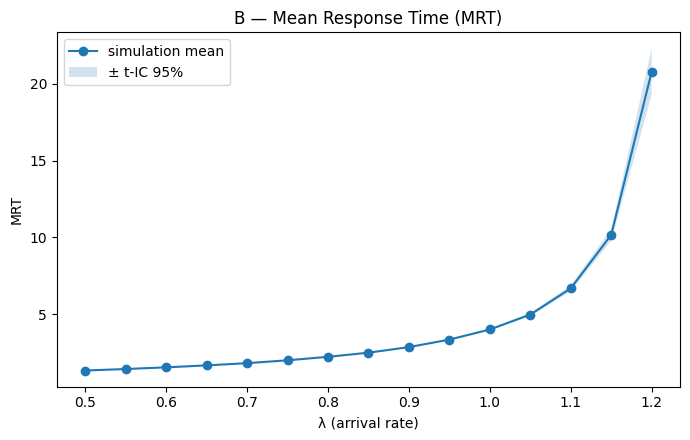

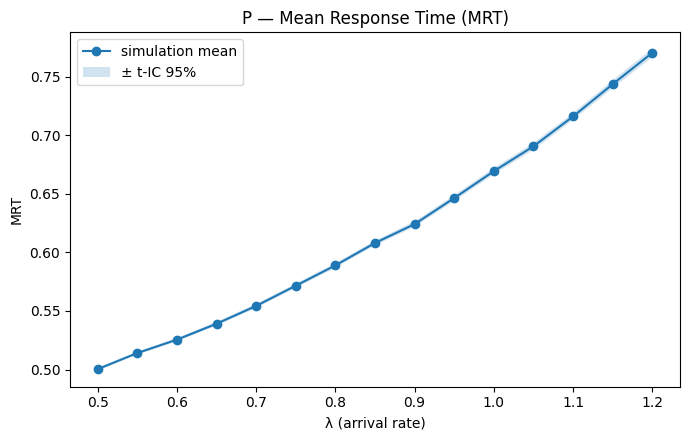

,SCOPE,ARRIVAL_RATE,mean,half,n_batches
0,A,0.50,0.359071,0.000962,256
1,A,0.55,0.380718,0.001094,256
2,A,0.60,0.402678,0.001227,256
3,A,0.65,0.428238,0.001372,256
4,A,0.70,0.456689,0.001564,256
5,A,0.75,0.492279,0.002044,256
6,A,0.80,0.531155,0.002562,256
7,A,0.85,0.576641,0.003043,256
8,A,0.90,0.626822,0.003569,256
9,A,0.95,0.697132,0.005009,256


In [9]:
# =================== ESEMPIO D'USO ===================
# Imposta i path secondo la tua struttura di progetto.

# CSV batch di simulazione (accetta anche pattern o lista):
batch_csv = '.output_simulation/obj1_arrivals.csv'  # <-- sostituisci se necessario

# Path della config usata per la sweep (serve solo per inferire il CSV analitico):
# Se non hai un file di config, puoi passare un path qualsiasi dello stesso progetto: la funzione cercherà
# 'analytic_sweep_lambda.csv' nella stessa cartella o in quella superiore.
config_path = '.output_simulation/analytic_sweep_lambda.csv'  # <-- sostituisci con la tua config, se presente

# Carica IC da batch
ci_df = ci_from_batches_mrt(batch_csv, conf=0.95)

# Carica modello analitico
try:
    analytic_df = load_analytic_models_for_config(config_path, base_dir=Path(config_path).parent)
except FileNotFoundError as e:
    # Fallback: se non troviamo il file analitico, creiamo un DataFrame vuoto per saltare il plot analitico
    print(f"ATTENZIONE: {e}")
    analytic_df = None

# Plotta le 4 figure: SYSTEM (con analitico) + A, B, P (solo sim)
if analytic_df is not None:
    plot_mrt_system_with_analytic(ci_df, analytic_df, conf=0.95)
else:
    print("Salto il confronto analitico (file non trovato). Visualizzo solo i nodi.")

# Nodi (se presenti nel CSV). Se un nodo manca, la funzione non produce figura.
for node in ["A", "B", "P"]:
    plot_mrt_node(ci_df, node, conf=0.95)

# Visualizza un estratto della tabella IC (prime righe)
ci_df.head(10)

In [11]:
# ------------------ IC tra batch: naive vs HAC ------------------

def _t_critical(conf: float, df: int) -> float:
    """
    Quantile t-Student (fallback normale se SciPy non disponibile).
    """
    alpha = 1.0 - conf
    try:
        from scipy.stats import t as student_t  # type: ignore
        return float(student_t.ppf(1.0 - alpha/2.0, df))
    except Exception:
        if df >= 30:
            # 95% / 99% comuni
            if abs(conf - 0.95) < 1e-9: return 1.96
            if abs(conf - 0.99) < 1e-9: return 2.576
            return 1.96
        # prudente per df piccoli
        return 2.20


def _autocovariances(y: np.ndarray, max_lag: int) -> np.ndarray:
    """
    Autocovarianze campionarie γ_j per j=0..max_lag.
    """
    y = np.asarray(y, dtype=float)
    y = y[np.isfinite(y)]
    n = len(y)
    mu = y.mean()
    gam = np.empty(max_lag + 1, dtype=float)
    for j in range(max_lag + 1):
        gam[j] = np.dot(y[:n-j] - mu, y[j:] - mu) / n
    return gam


def _hac_long_run_variance(y: np.ndarray, L: Optional[int] = None) -> float:
    """
    Stima LRV = γ_0 + 2 * Σ_{j=1..L} w_j γ_j con finestra di Bartlett (Newey–West).
    - Se L è None, usa regola L ≈ ceil(n^(1/3)).
    """
    y = np.asarray(y, dtype=float)
    y = y[np.isfinite(y)]
    n = len(y)
    if n < 2:
        return 0.0
    if L is None:
        L = int(np.ceil(n ** (1/3)))
    L = max(1, min(L, n-1))
    gam = _autocovariances(y, L)
    # Bartlett weights
    w = 1.0 - (np.arange(1, L+1) / (L + 1.0))
    lrv = gam[0] + 2.0 * np.sum(w * gam[1:])
    return float(max(lrv, 0.0))  # tronca a 0 se negativo per errori numerici


def ci_from_batches_mrt(batch_csv_input: Union[str, Path, pd.DataFrame, Iterable[Union[str, Path]]],
                        conf: float = 0.95,
                        method: str = "hac",
                        hac_max_lag: Optional[int] = None) -> pd.DataFrame:
    """
    Calcola media e semi-ampiezza IC per MRT raggruppando per (SCOPE, ARRIVAL_RATE).

    method:
      - 'naive' -> t-IC con std/√k (batch indipendenti)
      - 'hac'   -> t-IC con varianza corretta per autocorrelazione (Newey–West)

    Ritorna: SCOPE, ARRIVAL_RATE, mean, half, n_batches, r1 (lag-1), method.
    """
    df = _ensure_dataframe(batch_csv_input)
    df = _standardize_columns(df)

    required = {"SCOPE", "ARRIVAL_RATE", "BATCH_NUM"}
    if not required.issubset(df.columns):
        miss = required - set(df.columns)
        raise ValueError(f"Mancano colonne richieste nel CSV batch: {miss}")

    # Colonna MRT
    mrt_col = None
    for c in ["MEAN_RESPONSE_TIME", "mean_response_time", "MRT"]:
        if c in df.columns:
            mrt_col = c; break
    if mrt_col is None:
        raise ValueError("Colonna MRT non trovata (attesi: 'MEAN_RESPONSE_TIME'/'mean_response_time'/'MRT').")

    # Tipizza e pulisci
    df["ARRIVAL_RATE"] = pd.to_numeric(df["ARRIVAL_RATE"], errors="coerce")
    df["BATCH_NUM"]    = pd.to_numeric(df["BATCH_NUM"],    errors="coerce")
    df[mrt_col]        = pd.to_numeric(df[mrt_col],         errors="coerce")
    df = df.dropna(subset=["ARRIVAL_RATE", "BATCH_NUM", mrt_col])

    out_rows = []
    for (scope, lam), g in df.groupby(["SCOPE", "ARRIVAL_RATE"]):
        # Ordina per batch (time order)
        gi = g.sort_values("BATCH_NUM")
        y = gi[mrt_col].to_numpy()
        k = len(y)
        mu = float(np.mean(y))
        s = float(np.std(y, ddof=1)) if k > 1 else 0.0
        r1 = float(np.corrcoef(y[:-1], y[1:])[0,1]) if k > 2 and np.std(y[:-1])>0 and np.std(y[1:])>0 else np.nan

        if k <= 1 or s == 0.0:
            half = 0.0
        else:
            tcrit = _t_critical(conf, k-1)
            if method == "naive":
                half = tcrit * (s / math.sqrt(k))
            elif method == "hac":
                L = hac_max_lag
                lrv = _hac_long_run_variance(y, L=L)
                var_mean = lrv / k
                half = tcrit * math.sqrt(max(var_mean, 0.0))
            else:
                raise ValueError("method deve essere 'naive' o 'hac'.")

        out_rows.append({
            "SCOPE": scope,
            "ARRIVAL_RATE": lam,
            "mean": mu,
            "half": float(half),
            "n_batches": k,
            "r1": r1,
            "method": method
        })

    out = pd.DataFrame(out_rows).sort_values(["SCOPE", "ARRIVAL_RATE"]).reset_index(drop=True)
    return out

In [12]:
ci_naive = ci_from_batches_mrt('.output_simulation/obj1_arrivals.csv', conf=0.95, method="naive")
ci_hac   = ci_from_batches_mrt('.output_simulation/obj1_arrivals.csv', conf=0.95, method="hac")

# Differenza percentuale della semi-ampiezza su SYSTEM
m = ci_naive.merge(ci_hac, on=["SCOPE","ARRIVAL_RATE"], suffixes=("_naive","_hac"))
m_sys = m[m["SCOPE"].str.upper().isin(["OVERALL","SYSTEM"])]
m_sys["delta_%"] = 100*(m_sys["half_hac"] - m_sys["half_naive"]) / m_sys["half_naive"]
print(m_sys[["ARRIVAL_RATE","half_naive","half_hac","delta_%"]].round(4))


    ARRIVAL_RATE  half_naive  half_hac  delta_%
30          0.50      0.0067    0.0065  -3.2476
31          0.55      0.0084    0.0068 -19.2277
32          0.60      0.0098    0.0102   4.3386
33          0.65      0.0119    0.0108  -9.0984
34          0.70      0.0130    0.0130   0.7410
35          0.75      0.0170    0.0122 -28.0571
36          0.80      0.0213    0.0196  -7.7638
37          0.85      0.0280    0.0303   8.2339
38          0.90      0.0368    0.0421  14.4346
39          0.95      0.0535    0.0519  -2.9878
40          1.00      0.0691    0.0648  -6.1533
41          1.05      0.1034    0.0940  -9.0731
42          1.10      0.1935    0.1855  -4.1498
43          1.15      0.3979    0.4363   9.6557
44          1.20      1.5419    1.7618  14.2650


C:\Users\leopo\AppData\Local\Temp\ipykernel_20264\662093369.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_sys["delta_%"] = 100*(m_sys["half_hac"] - m_sys["half_naive"]) / m_sys["half_naive"]
